In [56]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests
import rioxarray
import xarray as xr
from s2cloudless import S2PixelCloudDetector

In [58]:
image_urls = [
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-01-01.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-01-29.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-02-26.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-03-26.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-04-23.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-05-21.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-06-18.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-07-16.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-08-13.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-09-10.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-10-08.tif",
    "https://storage.googleapis.com/fchouteau-isae-otsu/sentinel2monthly/sentinel2_toulouse_2022-11-05.tif",
]

In [59]:
def download_file(in_url: str, out_filename: Path):
    if not (out_filename).exists():
        out_filename.parent.mkdir(exist_ok=True)
        print("Downloading", in_url)
        response = requests.get(in_url)
        with open(out_filename, "wb") as f:
            f.write(response.content)

In [60]:
for image_url in image_urls:
    download_file(image_url, Path() / "sentinel2" / image_url.split("/")[-1])

In [69]:
image_paths = sorted(list((Path().resolve() / "sentinel2").glob("*.tif")))
image_paths = [str(image_path) for image_path in image_paths]
image_paths

['/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-01-01.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-01-29.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-02-26.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-03-26.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-04-23.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-05-21.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-06-18.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-07-16.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-08-13.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-09-10.tif',
 '/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-10-08.tif',

In [70]:
def plot_probabilities(image, proba):
    """Utility function for plotting a RGB image and its cloud probability map next to each other."""
    image = image.astype(np.float32) / 255.0

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(image)
    ax = plt.subplot(1, 2, 2)
    ax.imshow(proba, cmap=plt.cm.inferno)


def plot_image(image, mask):
    """Utility function for plotting RGB images and masks."""
    image = image.astype(np.float32) / 255.0

    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    mask_color = [255, 255, 0, 100]

    ax.imshow(image)

    cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

    cloud_image[mask == 1] = np.asarray(mask_color, dtype=np.uint8)

    ax.imshow(cloud_image)

## Applying a cloud detector to sentinel 2 images

We are downloading a timeseries of sentinel 2 L1C images in reflectance over Toulouse and we will apply a cloud detection model (trained by sentinelHub https://github.com/sentinel-hub/sentinel2-cloud-detector) to it to generate cloud masks

Here is a example of a script

In [71]:
cloud_detector = S2PixelCloudDetector(
    threshold=0.4, average_over=4, dilation_size=2, all_bands=False
)

In [72]:
def path_to_datetime(image_file: str):
    date = image_file.split("/")[-1].replace(".tif", "")
    date = date.split("_")[-1]
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return date


def read_image_rio(image_file: str):
    timestamp = path_to_datetime(image_file)
    with rasterio.open(image_file, "r") as riods:
        img = riods.read()

    return img, timestamp


def true_color_image(image: np.ndarray):
    # clip reflectance to 0. - 0.4
    img = image[[2, 1, 0], :, :]

    img = img.clip(0, 0.4) / 0.4
    img = (img * 255.0).astype(np.uint8)

    return img.transpose((1, 2, 0))


def get_cloud_probabilities(image: np.ndarray):
    image = image.transpose((1, 2, 0))[:, :, :-1]
    cloud_prob = cloud_detector.get_cloud_probability_maps(image)

    return cloud_prob


def get_cloud_mask(image: np.ndarray):
    image = image.transpose((1, 2, 0))[:, :, :-1]
    cloud_mask = cloud_detector.get_cloud_masks(image)

    return cloud_mask

Read one image using classical rasterio

In [73]:
image_file = image_paths[0]
image_file

'/home/fchouteau/classes/isae-otsu/_teacher/sentinel2/sentinel2_toulouse_2022-01-01.tif'

In [74]:
image, timestamp = read_image_rio(image_file)
preview = true_color_image(image)

/home/fchouteau/mambaforge/envs/py39-isae/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Plot the RGB true color image

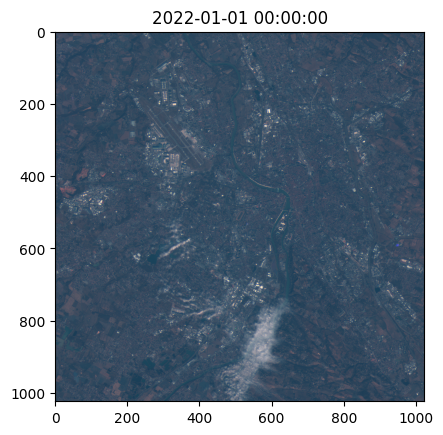

In [75]:
plt.title(timestamp)
plt.imshow(preview)
plt.show()

Get the cloud mask and cloud probabilities

In [76]:
cloud_probabilities = get_cloud_probabilities(image)
cloud_mask = get_cloud_mask(image)

Plot it

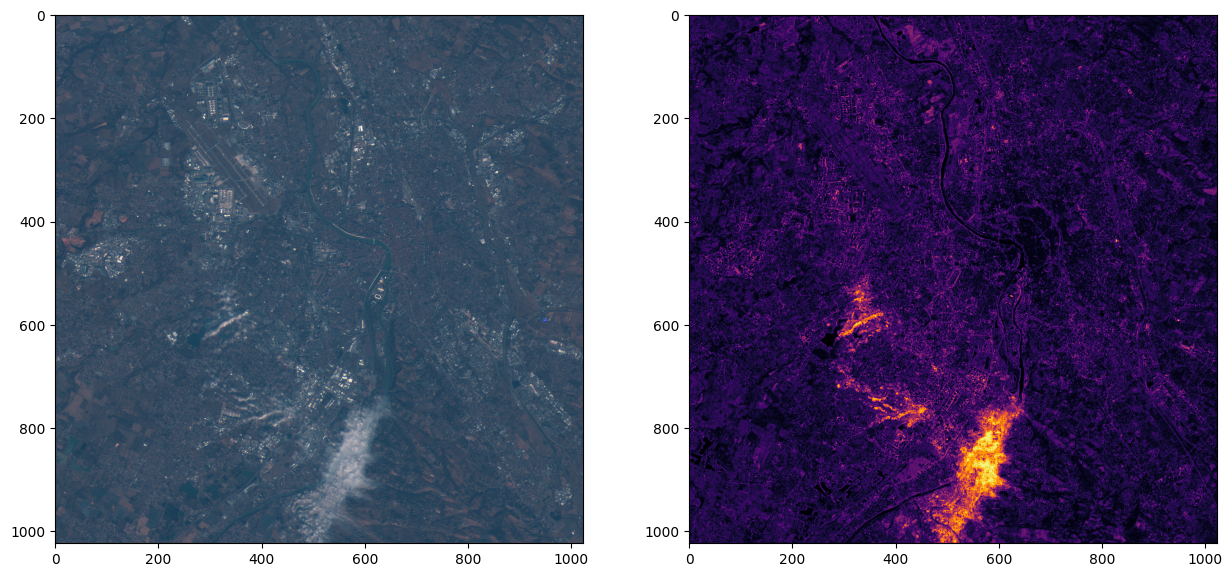

In [77]:
plot_probabilities(preview, cloud_probabilities)

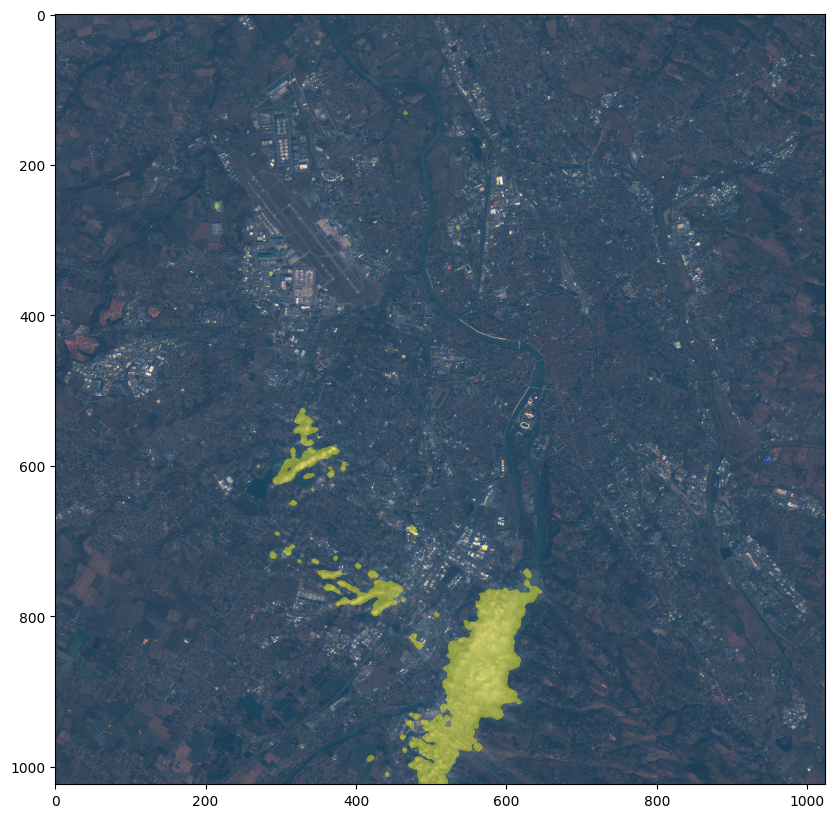

In [78]:
plot_image(preview, cloud_mask)

## Code conversion to dask / xarray

**Exercise 1:**

Apply the code that reads the images and generate the cloud masks to all of the images listed above.

Try to write it by thinking about how you would distribute it on several clusters or machines

**Exercice 2:**

From the beginning of the code below and from the functions defined above (it may require modifications), apply the cloud mask generation to the data timeseries in a "dask-fashion", and call .compute() to generate everything

In [79]:
def read_image(image_file):
    timestamp = path_to_datetime(image_file)
    img = rioxarray.open_rasterio(image_file, chunks=1024)
    return img, timestamp

In [80]:
# Put your new functions here

In [81]:
timeseries = [read_image(path) for path in image_paths]
timeseries, timestamps = zip(*timeseries)
timestamps = xr.Variable("time", list(timestamps))
timeseries = xr.concat(timeseries, dim=timestamps)

/home/fchouteau/mambaforge/envs/py39-isae/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/fchouteau/mambaforge/envs/py39-isae/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/fchouteau/mambaforge/envs/py39-isae/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/fchouteau/mambaforge/envs/py39-isae/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform

In [82]:
timeseries

<xarray.DataArray (time: 12, band: 11, y: 1024, x: 1024)>
dask.array<concatenate, shape=(12, 11, 1024, 1024), dtype=float32, chunksize=(1, 11, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.022e+03 1.022e+03 1.024e+03
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2022-01-01 2022-01-29 ... 2022-11-05
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [63]:
# your code here